# L'importation des bibliothéques nécessaires

*Cette section importe toutes les bibliothèques nécessaires pour le traitement des données, la visualisation, la modélisation et l'évaluation des performances.*

In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Attention, Input, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


# La lecture du data et la visualisation du Data

*Cette section permet de charger le fichier CSV contenant les données de ransomwares et de les afficher pour un aperçu initial.*

In [ ]:
from google.colab import files
import io

uploaded=files.upload()

Saving ransomware_dataset.csv to ransomware_dataset.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['ransomware_dataset.csv']))
print(data.head())

                                            FileName  \
0           0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll   
1       05c8318f98a5d301d80000009c316005.vertdll.dll   
2           06054fba-5619-4a86-a861-ffb0464bef5d.dll   
3        075822ac99a5d301660400009c316005.adhapi.dll   
4  090607dd9ba5d301ca0900009c316005.SensorsNative...   

                            md5Hash  Machine  DebugSize  DebugRVA  \
0  79755c51e413ed3c6be4635fd729a6e1      332          0         0   
1  95e19f3657d34a432eada93221b0ea16    34404         84    121728   
2  85c32641d77a54e19ba8ea4ab305c791      332          0         0   
3  62e3b959d982ef534b66f819fe15f085    34404         84     19904   
4  ae38c5f7d313ad0ff3bfb8826476767f    34404         84     97728   

   MajorImageVersion  MajorOSVersion  ExportRVA  ExportSize  IatVRA  \
0                  0               4          0           0    8192   
1                 10              10     126576        4930       0   
2                  0               

In [ ]:
print(data.describe())

            Machine     DebugSize      DebugRVA  MajorImageVersion  \
count  78556.000000  7.855600e+04  7.855600e+04       78556.000000   
mean    9482.336753  2.058922e+04  1.810962e+05          73.011597   
std    15113.745853  5.762681e+06  1.793627e+06        1225.034991   
min        0.000000  0.000000e+00  0.000000e+00           0.000000   
25%      332.000000  0.000000e+00  0.000000e+00           0.000000   
50%      332.000000  2.800000e+01  4.096000e+03           0.000000   
75%    34404.000000  5.600000e+01  3.276800e+04           8.000000   
max    43620.000000  1.615155e+09  2.852127e+08       63325.000000   

       MajorOSVersion     ExportRVA    ExportSize        IatVRA  \
count    78556.000000  7.855600e+04  7.855600e+04  7.855600e+04   
mean         5.867661  7.968689e+05  3.266691e+05  1.922440e+05   
std          2.692333  3.372625e+07  2.543482e+07  1.436287e+06   
min          0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%          4.000000  0.000000e+0

*Cette partie crée un graphique pour visualiser la répartition des fichiers sains et infectés dans le jeu de données.*

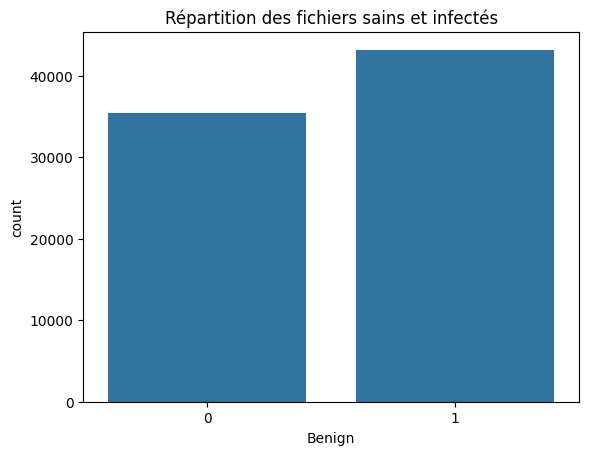

In [ ]:
sns.countplot(x='Benign', data=data)
plt.title('Répartition des fichiers sains et infectés')
plt.show()

# La matrice de Corrélation

*Cette section analyse et visualise les corrélations entre les variables numériques pour comprendre leurs relations.*

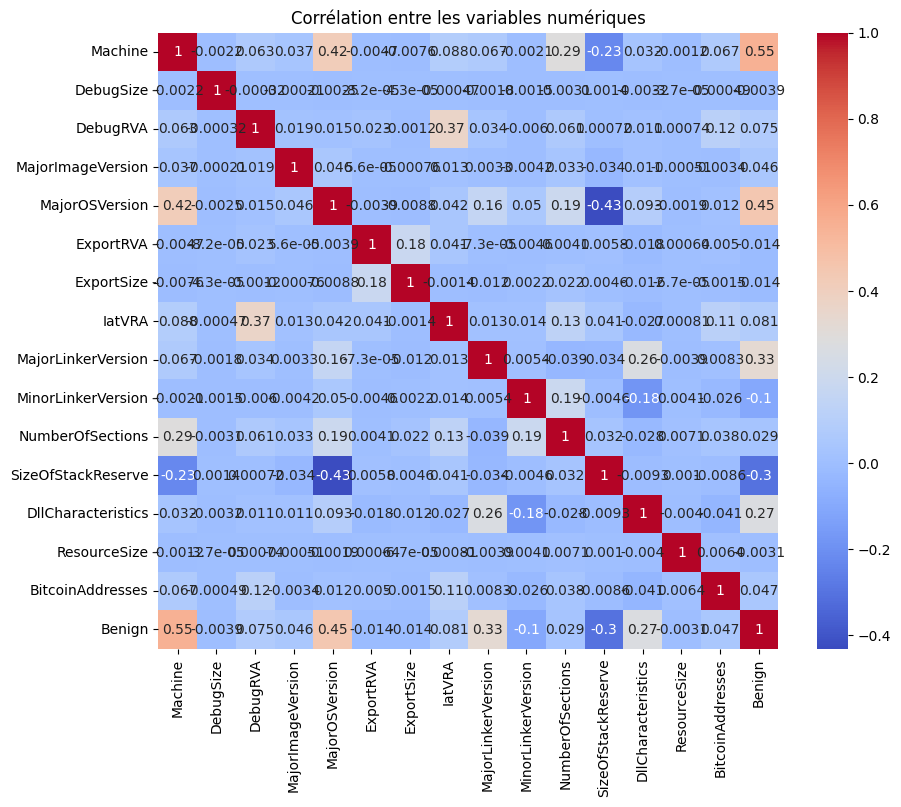

In [ ]:
numeric_cols = data.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Corrélation entre les variables numériques')
plt.show()

# La séparation et la division du Data

*Dans cette section, les données sont préparées pour l'entraînement du modèle. Les colonnes inutiles sont supprimées, les données sont standardisées, et divisées en ensembles d'entraînement, de validation et de test.*

In [ ]:
X = data.drop(['FileName', 'md5Hash', 'Benign'], axis=1)
feature_names = X.columns
y = data['Benign']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, y_train_initial, test_size=0.2, random_state=42)

# La génération du modéle

*Un modèle de réseau de neurones récurrent avec une couche d'attention est construit et entraîné. Le modèle utilise une architecture bidirectionnelle LSTM avec une couche d'attention pour se concentrer sur les parties importantes des séquences d'entrée.*

In [ ]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Remodelage des étiquettes pour correspondre à la sortie du modèle
y_train = np.reshape(y_train, (-1, 1))
y_val = np.reshape(y_val, (-1, 1))

input_layer = Input(shape=(X_train.shape[1], 1))


lstm_out = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)

attention = Attention()([lstm_out, lstm_out])
attention = Attention()([attention, attention]) # La couche d'attention a besoin d'une requête et d'une valeur, la clé est définie sur Aucune

flatten = Flatten()(attention)

output_layer = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=10, batch_size=64)

Epoch 1/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8497 - loss: 0.3429 - val_accuracy: 0.9492 - val_loss: 0.1454
Epoch 2/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9552 - loss: 0.1301 - val_accuracy: 0.9604 - val_loss: 0.1113
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9664 - loss: 0.1037 - val_accuracy: 0.9665 - val_loss: 0.0965
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9716 - loss: 0.0919 - val_accuracy: 0.9737 - val_loss: 0.0906
Epoch 5/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9689 - loss: 0.0933 - val_accuracy: 0.9753 - val_loss: 0.0815
Epoch 6/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9748 - loss: 0.0823 - val_accuracy: 0.9753 - val_loss: 0.0826
Epoch 7/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9736 - loss: 0.0824 - val_accuracy: 0.9777 - val_loss: 0.0798
Epoch 8/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9750 - loss: 0.0808 - val_acc

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print("L'erreur pour l'ensemble d'entraînement\n",loss)
print("L'erreur pour l'ensemble de validation\n",val_loss)

L'erreur pour l'ensemble d'entraînement
 [0.2436446100473404, 0.12618683278560638, 0.10348096489906311, 0.09391807019710541, 0.08849175274372101, 0.08647265285253525, 0.08030611276626587, 0.07790201902389526, 0.07247171550989151, 0.06861501187086105]
L'erreur pour l'ensemble de validation
 [0.14537689089775085, 0.111285001039505, 0.09652718156576157, 0.09061350673437119, 0.08149483799934387, 0.08258330076932907, 0.07977308332920074, 0.09422669559717178, 0.06810785830020905, 0.07416004687547684]


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("La précision pour l'ensemble d'entraînement\n",accuracy)
print("La précision pour l'ensemble de validation\n",val_accuracy)

La précision pour l'ensemble d'entraînement
 [0.9026156067848206, 0.9573545455932617, 0.9658478498458862, 0.9703431129455566, 0.9720934629440308, 0.9730283617973328, 0.9745201468467712, 0.9757135510444641, 0.9781004190444946, 0.9799104928970337]
La précision pour l'ensemble de validation
 [0.9492402076721191, 0.9603787064552307, 0.9665048718452454, 0.9736653566360474, 0.9752565622329712, 0.9753361344337463, 0.9777229428291321, 0.9770069122314453, 0.9805871844291687, 0.9795528650283813]


# Évaluation de la performance

*Cette section évalue les performances du modèle sur les données de test en utilisant des métriques comme la précision, le rappel, la F-mesure et la matrice de confusion. Les résultats sont affichés pour l'ensemble d'entraînement et de validation.*

In [ ]:
test_predictions = model.predict(X_test)
test_predictions_classes = (test_predictions > 0.5).astype(int)

491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
accuracy = accuracy_score(y_test, test_predictions_classes)
precision = precision_score(y_test, test_predictions_classes)
recall = recall_score(y_test, test_predictions_classes)
f1 = f1_score(y_test, test_predictions_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Rappel:", recall)
print("F-mesure:", f1)

Accuracy: 0.9786150712830958
Precision: 0.9886972733628525
Rappel: 0.9726043099495644
F-mesure: 0.9805847682884549


# La matrice du Confusion

In [ ]:
classification_report_result = classification_report(y_test, test_predictions_classes)

# Afficher le rapport de classification
print("Rapport de classification:\n", classification_report_result)

Rapport de classification:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      6988
           1       0.99      0.97      0.98      8724

    accuracy                           0.98     15712
   macro avg       0.98      0.98      0.98     15712
weighted avg       0.98      0.98      0.98     15712



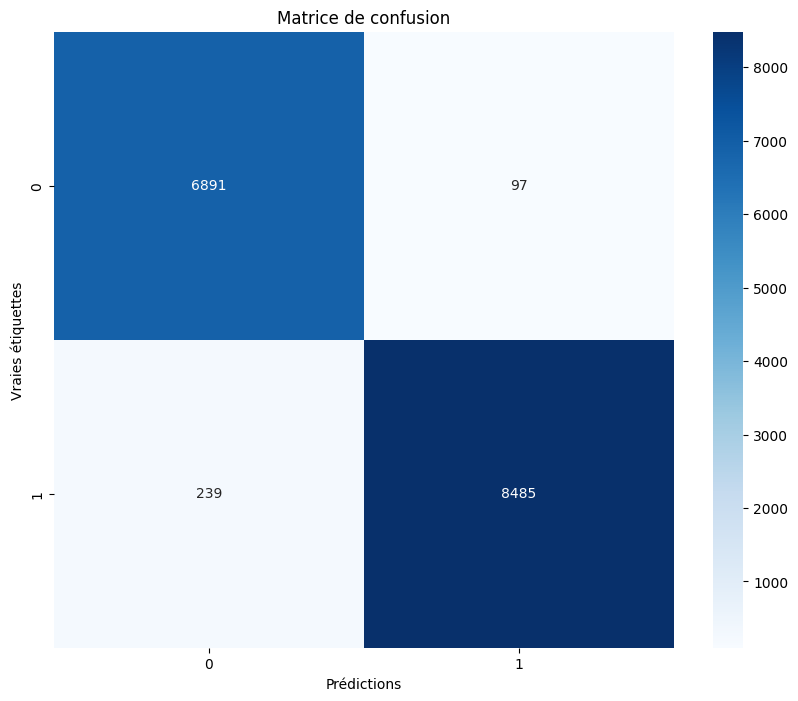

In [ ]:
conf_matrix = confusion_matrix(y_test, test_predictions_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.show()

# Optimisation du modèle

*Cette section utilise la recherche par grille pour optimiser les hyperparamètres du modèle, tels que le type de fonction de perte, l'optimiseur, la taille du lot et le poids de classe.*

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.layers import Input, LSTM, Bidirectional, Flatten, Dense
from keras.models import Model
from keras.layers import Attention

# Définir une fonction pour créer le modèle avec les hyperparamètres à optimiser
def create_model(optimizer='adam', loss='binary_crossentropy', attention_units=64, lstm_units=64, dropout_rate=0.2):
    input_layer = Input(shape=(X_train.shape[1], 1))
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(input_layer)
    attention = Attention()([lstm_out, lstm_out])
    flatten = Flatten()(attention)
    output_layer = Dense(1, activation='sigmoid')(flatten)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

# Créer le modèle KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
    'optimizer': ['adam', 'SGD'],
    'loss': ['binary_crossentropy'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20],
    'class_weight': [None, 'balanced']
}

# Réaliser la recherche par grille
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search_result = grid_search.fit(X_train_reshaped, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search_result.best_params_)
print("Meilleur score:", grid_search_result.best_score_)


Meilleurs paramètres: {'batch_size': 32, 'class_weight': None, 'epochs': 20, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
Meilleur score: 0.9817603051864217


*Cette dernière section évalue les performances du modèle optimisé sur les données de test, en affichant les mêmes métriques de performance que précédemment.*

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Obtenez le meilleur modèle à partir des résultats de la recherche par grille
best_model = grid_search_result.best_estimator_

# Prédire les étiquettes sur l'ensemble de test
y_pred = best_model.predict(X_test_reshaped)

# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher les résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:")
print(conf_matrix)


Accuracy: 0.9803971486761711
Precision: 0.9880538158199954
Recall: 0.9765016047684548
F1 score: 0.9822437449556094
Confusion matrix:
[[6885  103]
 [ 205 8519]]


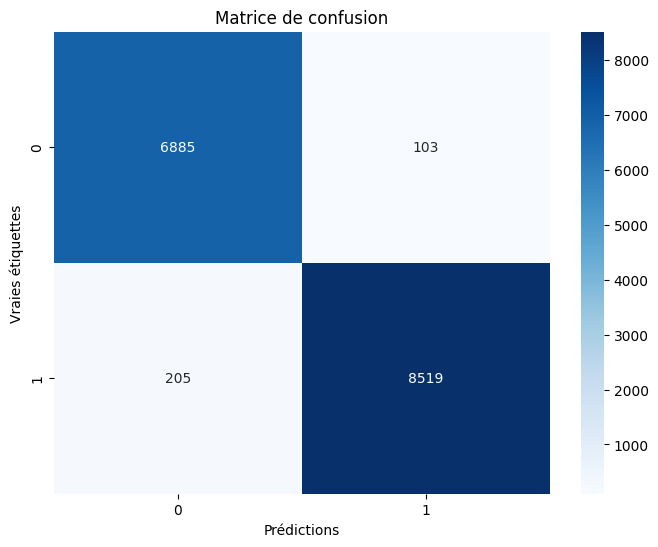

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Afficher la matrice de confusion sous forme graphique
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.show()